# Assembly algorithm

This script performs the assembly algorithm. It contains the following steps:
- Loading and cleaning read data and reference genome data
- Visualizing overlap between reads
- Collapsing the regions where there is empty data
- Sliding a window over the region of interest to identify reads

# Load Modules

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Reference Genome

Info: https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use

S3 nanopore directory:

s3cmd get --recursive s3://aretian-genomics/nanopore/

In [4]:
# Pull reference genome from S3
# !s3cmd get s3://aretian-genomics/nanopore/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# !gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz

# Index reference genome
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna

# Select chromosomes or regions
# !samtools faidx GCA_000001405.15_GRCh38_no_alt_analysis_set.fna chr17 > chr17_selected.fa

## Extract Chromosome 17

Extract Chr17 from reference genome.

In [7]:
# Read in fasta file: remove line breaks and header
def read_fasta_genome(fasta_file,chromosome_header):
    clean_data = fasta_file.read().replace("\n", "")
    clean_data = clean_data.replace(chromosome_header,"") # get rid of header

    return clean_data

with open('../../data/processed/chr17_selected.fa') as f: # update path if needed
    ref_genome = read_fasta_genome(f,'>chr17')

# See https://www.bioinformatics.org/sms/iupac.html for IUPAC nucleotide codes

print(f"Unique characters: {list(set(ref_genome))}") 

print(f"Selected chromosome from reference genome is {len(ref_genome)} BP long")

Unique characters: ['C', 'R', 'S', 'Y', 'K', 'W', 'A', 'T', 'G', 'N']
Selected chromosome from reference genome is 83257441 BP long


# Load Reads

Samtools view --> format of output: http://samtools.github.io/hts-specs/SAMv1.pdf

In [10]:
#!view -c bioliquid_chr17_pompe.bam
#!samtools view bioliquid_chr17_pompe.bam | head -n 500 > bioliquid_chr17_pompe_500reads.txt

In [10]:
nanopore_reads = pd.read_csv('../../data/processed/bioliquid_chr17_pompe_reads.csv')

## Clean Reads

In [695]:
# Sort and get ID
nanopore_reads = nanopore_reads.sort_values(by='POS',ascending=True) # sort based on starting index of reads
nanopore_reads = nanopore_reads.reset_index()
nanopore_reads['ID'] = nanopore_reads.index
# Get columns of interest
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR', 'RNEXT', 'PNEXT','TLEN', 'SEQ', 'QUAL']]
# Drop missing values
nanopore_reads = nanopore_reads.loc[nanopore_reads['SEQ'] != '*'] # drop any rows without a proper nucleotide sequence

# Descriptive Statistics of Reads

In [678]:
# for ID in nanopore_reads.index:
#     print(f"Leftmost index --> {nanopore_reads.loc[ID,'POS']}, Read length --> {len(nanopore_reads.loc[ID,'SEQ'])}")

In [14]:
end_index = max(nanopore_reads['POS']) + len(nanopore_reads.loc[nanopore_reads['POS'].idxmax(),'SEQ'])
start_index = min(nanopore_reads['POS'])
index_range = end_index-start_index

In [15]:
read_overlap = np.zeros((len(nanopore_reads),index_range)) # empty matrix for reads

In [16]:
for ID in nanopore_reads.index:
#     print(f"Adding raad cover for read {ID+1}: Index-->{nanopore_reads.loc[ID,'POS']}, length-->{len(nanopore_reads.loc[ID,'SEQ'])}")
    start = nanopore_reads.loc[ID,'POS']-start_index
    #print(start)
    end = start+len(nanopore_reads.loc[ID,'SEQ'])
    #print(end)
    read_overlap[ID,start:end] = 1
    
summary = read_overlap.sum(axis=0)

In [17]:
overlap_df = pd.DataFrame(data=summary,index=range(start_index,end_index), columns=['overlap_count'])
overlap_df['position'] = overlap_df.index

## Plot read overlap

In [18]:
# len(overlap_df)
# i=1
# overlap_df.loc[i,'isempty']

In [19]:
overlap_df['isempty']=overlap_df['overlap_count']==0
win_length=10000
emptycount = 0
emptyregioncounter = 0

for i in overlap_df.index:
    
    if overlap_df.loc[i,'isempty']==False:
        emptycount = 0
        continue
        
    emptycount += 1
    
    if emptycount >= win_length:
        emptyregioncounter +=1
        
    if i%100000==0:
        print(f"Loop: {i}")

Loop: 23400000
Loop: 23800000
Loop: 23900000
Loop: 24100000
Loop: 24300000
Loop: 24400000
Loop: 24500000
Loop: 24600000
Loop: 25100000
Loop: 25700000
Loop: 26200000
Loop: 26900000


In [20]:
print(f"There are at most {emptyregioncounter} regions with lengths larger than {win_length}")

There are at most 115460 regions with lengths larger than 10000


Text(0, 0.5, '# Reads Overlapping')

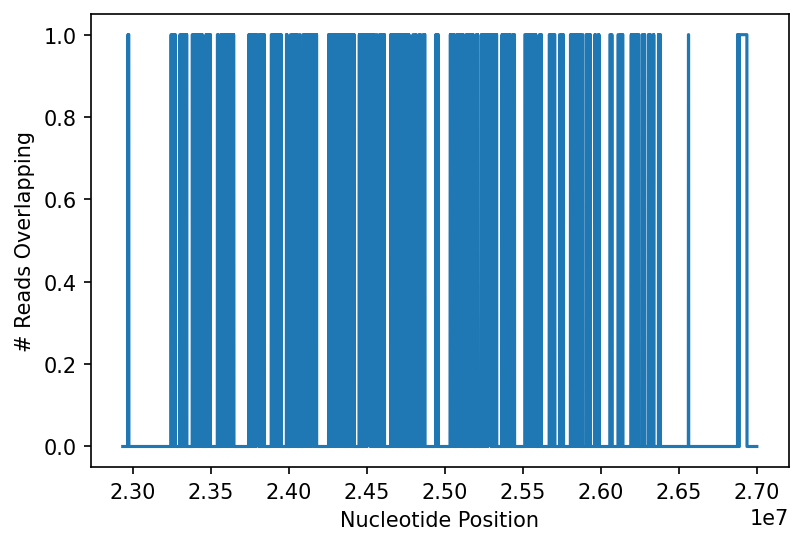

In [21]:
fig, ax = plt.subplots(dpi=150)
# plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
# plt.plot(overlap_df[:40000]['position'],overlap_df[:40000]['overlap_count'])
# plt.plot(overlap_df.loc[1000000:,'position'],overlap_df.loc[1000000:,'overlap_count'])
# plt.plot(overlap_df['position'],overlap_df['overlap_count'])
plt.plot(overlap_df['position'],overlap_df['isempty'])
plt.xlabel('Nucleotide Position')
plt.ylabel('# Reads Overlapping')

## Read Length and Position

In [22]:
# Check read length statistics
nanopore_reads['SEQ_LEN'] = nanopore_reads['SEQ'].apply(lambda x: len(x))
nanopore_reads['END_POS'] = nanopore_reads['POS']+nanopore_reads['SEQ_LEN']
print(f"Read length statistics:")
nanopore_reads['SEQ_LEN'].describe()

Read length statistics:


count     4689.000000
mean      2619.030497
std       7059.085360
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      32759.000000
Name: SEQ_LEN, dtype: float64

In [23]:
# Check read pos statistics
print(f"Read position statistics:")
nanopore_reads['POS'].describe()

Read position statistics:


count    4.689000e+03
mean     2.502001e+07
std      1.405861e+06
min      2.293697e+07
25%      2.360883e+07
50%      2.500124e+07
75%      2.651392e+07
max      2.699905e+07
Name: POS, dtype: float64

Trim reference genome chromosome to locus of interest 

In [24]:
ref_genome = ref_genome[min(nanopore_reads['POS']):max(nanopore_reads['END_POS'])]
print(f"Selected focus are for chromosome from reference genome is {len(ref_genome)} BP long")

Selected focus are for chromosome from reference genome is 4085413 BP long


# Collapse Gaps 

Steps 1-3 handled above already.
1. import genome (80 M)
2. import nanopore reads (4M cover range)
3. trim genome to min/max nanopore reads

4. Reset start and end position based on min read

In [25]:
shift = min(nanopore_reads['POS'])

# archive old positions
nanopore_reads['ORIG_POS'] = nanopore_reads['POS']
nanopore_reads['ORIG_END_POS'] = nanopore_reads['END_POS']

# shift positions
nanopore_reads['POS'] = nanopore_reads['POS']-shift
nanopore_reads['END_POS'] = nanopore_reads['END_POS']-shift

5. Remove gaps from nanopore reads and shift indices

In [26]:
nanopore_reads = nanopore_reads.reset_index() # to make the next step easier
nanopore_reads = nanopore_reads[['ID', 'QNAME', 'FLAG', 'RNAME', 'POS', 'MAPQ', 'CIGAR','RNEXT', 'PNEXT', 'TLEN', 'SEQ', 'QUAL', 'SEQ_LEN', 'END_POS','ORIG_POS', 'ORIG_END_POS']]

In [27]:
confirmed_gaps2 = []
for index in nanopore_reads.index:
    try:
        current_read_end = nanopore_reads.loc[index,'END_POS']
        
        gaps = []
        for index2 in nanopore_reads.index:
            try:
                if index == index2:
                    continue

                next_read_start = nanopore_reads.loc[index+1,'POS']

                delta = next_read_start-current_read_end


                if delta < 0: # There is overlap
                    continue 
                elif delta==0: # There is a single nucleotide overlap
                    continue
                elif delta > 0: # There is a gap
                    gaps.append((current_read_end+1,next_read_start-1)) # range between the values
            except:
                pass
            
                
                
        minimum_gap = min(gaps, key = lambda x: x[1]-x[0])
        confirmed_gaps2.append(minimum_gap)
        
    except:
        pass

print(f"There are {len(confirmed_gaps2)} gaps")
    

There are 3503 gaps


In [28]:
confirmed_gaps = []

for index in nanopore_reads.index:
 
    try:
        current_read_end = nanopore_reads.loc[index,'END_POS']

        next_read_start = nanopore_reads.loc[index+1,'POS']

        delta = next_read_start-current_read_end


        if delta < 0: # There is overlap
            continue 
        elif delta==0: # There is a single nucleotide overlap
            continue
        elif delta > 0: # There is a gap
            gap = (current_read_end+1,next_read_start-1)
            confirmed_gaps.append(gap) # range between the values
            
            # Adjust remainding reads 
            shift = gap[0]-gap[1]
            nanopore_reads.loc[index:,'POS'] = nanopore_reads.loc[index:,'POS']-shift
            nanopore_reads.loc[index:,'END_POS'] = nanopore_reads.loc[index:,'END_POS']-shift
                
    except:
        pass
            

print(f"There are {len(confirmed_gaps)} gaps")

There are 3503 gaps


In [29]:
confirmed_gaps==confirmed_gaps2 # TALK TO FER ABOUT THIS

False

6. Adjust reference_genome based on removed indices

In [30]:
indices_to_remove = []
for gap in confirmed_gaps:
    for i in range(gap[0],gap[1]):
        indices_to_remove.append(i)

In [31]:
print(f"Removing {len(indices_to_remove)} positions")

Removing 3438552 positions


In [32]:
len(temp_ref_genome)

NameError: name 'temp_ref_genome' is not defined

In [ ]:
max(indices_to_remove)

In [ ]:
temp_ref_genome = list(ref_genome)
for index in sorted(indices_to_remove, reverse=True):
    del temp_ref_genome[index]
ref_genome = ''.join(temp_ref_genome)
print(f"Selected focus are for chromosome from reference genome is {len(ref_genome)} BP long")

# Sliding Window Clustering

In [33]:
# Define hyper-parameters
window_width = 5000 # 5k BP
jump_width = 1000 # 1k BP sliding window (ideally jump_width=1)

## Import Modules

In [36]:
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

Helper functions

In [37]:
# check if the start of a sequence is in range
def check_sliding_window(read):
    read_filter = False
    window = set(list(range(left_bound,right_bound)))
    read = set(list(range(read['POS'],read['END_POS'])))
    if len(window & read)>0:
        read_filter = True
    return read_filter

In [54]:
# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def left_pad_read(read):
    nucleotide_sequence = list(read['SEQ']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)
    
    start = read['POS']-left_bound

    if start == 0:
        return read['SEQ'] # read starts on the start of the window
    
    elif start > 0: # sequence starts to the right of the bound
#         print('HERE1')
#         genome_fill = window_ref_genome[:start] # select portion of reference genome to pad the left with
        genome_fill = genome_sequence[:start] # select portion of reference genome to pad the left with
#         print('genome_fill type:', type(genome_fill))
#         print('nucleotide_sequence type:', type(nucleotide_sequence))
        nucleotide_sequence = genome_fill+nucleotide_sequence
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif start < 0: # sequence starts to the left of the bound
#         print('HERE2')
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[np.abs(start):])
        return nucleotide_sequence_trimmed

In [39]:
# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def right_pad_read(read):
    nucleotide_sequence = list(read['left_padded']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)

    end = right_bound-read['END_POS']

    if end == 0:
        return read['left_padded'] # read end on the end of the window
    
    elif end > 0: # sequence ends to the left of the bound
#         genome_fill = window_ref_genome[-end:] # select portion of reference genome to pad the right with
        genome_fill = genome_sequence[-end:] # select portion of reference genome to pad the right with
        nucleotide_sequence = nucleotide_sequence+genome_fill
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif end < 0: # sequence ends to the right of the bound
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[:end])
        return nucleotide_sequence_trimmed

In [40]:
# Should be updated
NUCLEOTIDE_VOCABULARY = [
    'A','C','G','T','X'
]
        
# Not being used, instead, we use the sklearn one hot encoding
def nucleotide_to_one_hot(nucleotide_sequence):
    to_return = []
    for char in nucleotide_sequence:
        if char in NUCLEOTIDE_VOCABULARY:
            to_append = np.zeros(len(NUCLEOTIDE_VOCABULARY))
            to_append[NUCLEOTIDE_VOCABULARY.index(char)] = 1.
            to_return.append(to_append)
        else:
            raise ValueError('Could not one-hot code character {}'.format(char))
    return np.array(to_return)

#nucleotide_to_one_hot('GTCATACX') # uncomment example to see what the encoding does

In [41]:
# Input: read (Series)
def write_results_to_file(read):
    results_file = open(f"../{runID}-{chromosomeID}.txt","a+")
    results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
#     results_file.close()

Text file for results

## Create results file

In [55]:
runID = 'run1'
chromosomeID = 'chr17'
results_file = open(f"../{runID}-{chromosomeID}.txt","w+")

In [56]:
# results_file.write('Hello world!')
# results_file.close()

In [57]:
# f = open("myfile.txt", )
# f.write("Hello World!")
# f.close()

## Main Loop

In [58]:
genome_index_count = 0
empty_count = 0

for left_bound in range(min(nanopore_reads['POS']),max(nanopore_reads['END_POS']),jump_width):
    
    right_bound = left_bound+window_width
#     genome_index_count = 0
    window_ref_genome = ref_genome[genome_index_count:genome_index_count+window_width]
#     genome_index_count + ~23M = left_bound
    
#     print("Identifying if each read is in the window...")
    # Identify if each read is in the window: True/False
    nanopore_reads['read_filter'] = nanopore_reads.apply(lambda x: check_sliding_window(x), axis=1)
    # Get them
    window_reads = nanopore_reads.loc[nanopore_reads['read_filter']==True]
    window_reads = window_reads.reset_index()
    
    if empty_count%100 == 0:
        print(empty_count)

    if len(window_reads) == 0:
        # There are no nanopore reads in this window (next window)
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue 
    elif len(window_reads) == 1:
        # There is only one read in this window (next window) - TODO: TALK WITH TEAM ABOUT THIS
        genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        continue
        
    ## If it gets here, there is more than one sequence overlapping in the window (continue algorithm to encoding and clustering steps) ##
    
#     print("Applying padding...")
    window_reads['left_padded'] = window_reads.apply(lambda x: left_pad_read(x), axis=1) # fill reference genome on the left of the read
    
    window_reads['right_padded'] = window_reads.apply(lambda x: right_pad_read(x), axis=1) # fill reference genome on the right of the read
    
    window_reads['final_padded_read'] = window_reads['right_padded']
    
    window_reads['FINAL_SEQ_LEN'] = window_reads['final_padded_read'].apply(lambda x: len(x)) # should always be 5k
    
    # not currently used. Should be used if we use the custom one-hot-encoding
#     window_reads['one_hot_read_V1'] = window_reads['final_padded_read'].apply(lambda x: nucleotide_to_one_hot(x).flatten())  # apply one-hot encoding V1
    
    unique_reads = []
    for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
        unique_reads.append(list(read['final_padded_read']))

    # One hot encoder
#     print("Running one hot encoder...")
    X = encoder.fit_transform(unique_reads).toarray()

    # PCA
#     print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    window_reads['PCA1'] = np.nan
    window_reads['PCA2'] = np.nan
    for ID in window_reads.index:
        window_reads.loc[ID,'PCA1'] = X_pca[ID][0].round(5) # TODO: change rounding if desired
        window_reads.loc[ID,'PCA2'] = X_pca[ID][1].round(5) # TODO: change rounding if desired
        
    # Standardizing the features
    X = window_reads[['PCA1','PCA2']]
    X = StandardScaler().fit_transform(X)

#     print("Running Kmeans...")
    model = KMeans(n_clusters=2, random_state=42)
    cls2 = model.fit(X)
    window_reads['kmeans_cls2'] = cls2.labels_
    
    window_reads.apply(lambda x: write_results_to_file(x), axis=1) # write results to file
    results_file.close()
    
    genome_index_count += jump_width # move the starting cutoff for the reference genome with the sliding window
    
#     print(empty_count)
    
    # Break after N iterations
    print(f"genome_index_count: {genome_index_count}")
#     if genome_index_count>100000:
#         break
        
#     break
    

0
genome_index_count: 28000
genome_index_count: 29000
genome_index_count: 30000
genome_index_count: 31000
genome_index_count: 32000
genome_index_count: 48000
genome_index_count: 50000
genome_index_count: 51000
genome_index_count: 52000
genome_index_count: 53000
genome_index_count: 54000
genome_index_count: 55000
genome_index_count: 56000
genome_index_count: 57000
genome_index_count: 58000
genome_index_count: 59000
genome_index_count: 60000
genome_index_count: 61000
genome_index_count: 62000
genome_index_count: 63000
genome_index_count: 64000
genome_index_count: 65000
genome_index_count: 66000
genome_index_count: 67000
genome_index_count: 68000
genome_index_count: 69000
genome_index_count: 70000
genome_index_count: 71000
genome_index_count: 72000
genome_index_count: 73000
genome_index_count: 74000
genome_index_count: 75000
genome_index_count: 76000
genome_index_count: 77000
genome_index_count: 78000
genome_index_count: 79000
genome_index_count: 80000
genome_index_count: 81000
genome_ind

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

# NOTES

## Next steps

- Count gaps.
- Assume there are no gaps. Continue just with the filled in reference genome.
- Then the only problem is the clustering switching.
- Apply crawling solution
    1. Append window id to final txt output
    2. Analyze output file and iteratively assign groups: cluster tag VS person
        - Choose label for first read
        - Apply persons to cluster tags
        
## Next next steps

1. Fill in with the reference genome
2. Collapse the empty spaces


In [157]:
# Input: read (Series)
def write_results_to_file(read):
#     print(read)
    print(read['ID'])
#     results_file = open(f"../{runID}-{chromosomeID}.txt","a+")
#     results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
#     print(f"{read['ID']},{read['kmeans_cls2']}\n")
#     f"{read['ID']}
#     results_file.close()

In [145]:
f"{window_reads.loc[0]['ID']}"

'63'

In [158]:
window_reads.apply(lambda x: write_results_to_file(x), axis=0) # write results to file

63
1022


0    None
1    None
dtype: object

In [141]:
# DEBUGGING
# results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
window_reads.apply(lambda x: write_results_to_file(x)) # write results to file
# results_file.close()

KeyError: 'ID'

In [137]:
window_reads.head()

,index,ID,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,...,SEQ_LEN,END_POS,read_filter,left_padded,right_padded,final_padded_read,FINAL_SEQ_LEN,PCA1,PCA2,kmeans_cls2
0,63,63,7989fa5c-d565-486b-87bb-452f61888d68,16,chr17,22975697,2,21598S15M1I10M1D28M4D10M1D5M2D3M2D5M2D16M2D16M...,*,0,...,32759,23008456,True,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,5000,-34.8425,0.0,0
1,1022,1022,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,...,32759,23011191,True,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,AGAAAATTCTCTGGGATGATTGAGTTGAACTCACAGAGCAGTACTT...,5000,34.8425,0.0,1


In [77]:
window_reads.head()

,index,ID,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,RNEXT,PNEXT,TLEN,SEQ,QUAL,SEQ_LEN,END_POS,read_filter
0,63,63,7989fa5c-d565-486b-87bb-452f61888d68,16,chr17,22975697,2,21598S15M1I10M1D28M4D10M1D5M2D3M2D5M2D16M2D16M...,*,0,0,TTGACTCGTATTTATCACAAACAAGTTTTGTATGCCTCTCTCGGTT...,NaN,32759,23008456,True
1,1022,1022,ebdd1129-003a-4f8d-acb4-72f40f4bbec8,16,chr17,22978432,1,6925S15M1D2M1D9M1D52M2I4M1D10M5D76M1I4M2I70M1D...,*,0,0,AATGTATTGCTGAAACTCTCTCGTGATGATTGCATTCAACTCACAG...,NaN,32759,23011191,True


In [80]:
list(window_reads.loc[0,'SEQ'])

['T',
 'T',
 'G',
 'A',
 'C',
 'T',
 'C',
 'G',
 'T',
 'A',
 'T',
 'T',
 'T',
 'A',
 'T',
 'C',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'G',
 'T',
 'T',
 'T',
 'T',
 'G',
 'T',
 'A',
 'T',
 'G',
 'C',
 'C',
 'T',
 'C',
 'T',
 'C',
 'T',
 'C',
 'G',
 'G',
 'T',
 'T',
 'A',
 'T',
 'G',
 'A',
 'T',
 'A',
 'A',
 'T',
 'T',
 'T',
 'C',
 'G',
 'T',
 'T',
 'T',
 'T',
 'T',
 'C',
 'A',
 'C',
 'C',
 'A',
 'G',
 'C',
 'T',
 'G',
 'G',
 'A',
 'A',
 'T',
 'C',
 'T',
 'C',
 'C',
 'A',
 'A',
 'T',
 'G',
 'T',
 'T',
 'C',
 'A',
 'T',
 'G',
 'A',
 'G',
 'T',
 'T',
 'A',
 'C',
 'G',
 'A',
 'A',
 'A',
 'C',
 'A',
 'C',
 'G',
 'T',
 'T',
 'T',
 'C',
 'T',
 'C',
 'A',
 'T',
 'T',
 'G',
 'T',
 'T',
 'T',
 'T',
 'T',
 'A',
 'T',
 'G',
 'A',
 'A',
 'C',
 'T',
 'G',
 'A',
 'A',
 'A',
 'C',
 'T',
 'A',
 'A',
 'A',
 'C',
 'T',
 'C',
 'T',
 'G',
 'T',
 'G',
 'A',
 'G',
 'T',
 'T',
 'T',
 'G',
 'A',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'T',
 'C',
 'A',
 'C',
 'A',
 'G',
 'A',
 'G',
 'A',
 'A',
 'G'

In [82]:
unique_reads = []
for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
    unique_reads.append(list(read['SEQ']))

In [83]:
unique_reads

In [88]:
len(unique_reads[1])

32759

In [84]:
X = encoder.fit_transform(unique_reads).toarray()
X

array([[0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 1.]])

In [ ]:
window_reads

# EXTRA CODE
Optimize number of clusters. Not needed in this case.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the features
X = test[['PCA1','PCA2']]
X = StandardScaler().fit_transform(X)

distortions = []

for k in range(1, 5):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(1, 5), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')

In [ ]:
silhouette_scores = []
for k in range(2, 5):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)

In [ ]:
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer3 = KElbowVisualizer(KMeans(), k=(2,5))

visualizer3.fit(X) # Fit the data to the visualizer

In [ ]:
model = KMeans(n_clusters=2, random_state=42)
cls2 = model.fit(X)
test['kmeans_cls2'] = cls2.labels_

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

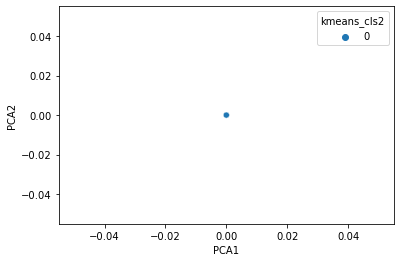

In [442]:
import seaborn as sns
sns.scatterplot(data=window_reads,x='PCA1',y='PCA2',hue='kmeans_cls2')